# 1D square wave, first order, periodic BC

$$
u_t + u_x = 0, \ (x, t) \in [0, 1]\times [0, 10].
$$
IC:
$$
f(x) = u(x, 0) = 1, \ x\in [1/4, 1/2], \ u = 0 \ \text{elsewhere}
$$

Periodic BC.


Sol:
$$
u(x, t) = f(x-t) = f(x-t - \lfloor{x-t}\rfloor).
$$

In [1]:
NAME = "3_relu_last_layer_nonuniform_layers"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *

from collections import namedtuple

In [3]:
def siren_layer_params(key, scale, m, n):
	w_key, b_key = random.split(key)
	return random.uniform(w_key, (m, n), jnp.float32, minval = -scale, maxval = scale), jnp.zeros((n, ), jnp.float32)

def init_siren_params(key, layers, c0, w0, w1):
	keys = random.split(key, len(layers))
	return [siren_layer_params(keys[0], w0*jnp.sqrt(c0/layers[0]), layers[0], layers[1])] + \
			[siren_layer_params(k, jnp.sqrt(c0/m), m, n) for m, n, k in zip(layers[1:-2], layers[2:-1], keys[1:-2])] + \
			[siren_layer_params(keys[-1], w1*jnp.sqrt(c0/layers[-2]), layers[-2], layers[-1])]

layers = [2] + [32, 64, 128, 256, 128, 64, 32] + [1]
c0 = 1.0
w0 = 2.0
w1 = 1.0
lambda_0 = 0
direct_params = init_siren_params(random.PRNGKey(0), layers, c0, w0, w1)


@jax.jit
def direct_model(params, xt):
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jax.nn.relu(jnp.dot(xt, params[-1][0])) + params[-1][1]
				   
jacobian = lambda params, xt: jax.jit(jax.vmap(jax.jacobian(direct_model, 1), (None, 0)))(params, xt)
hessian = lambda params, xt: jax.jit(jax.vmap(jax.hessian(direct_model, 1), (None, 0)))(params, xt)

<IPython.core.display.Javascript object>


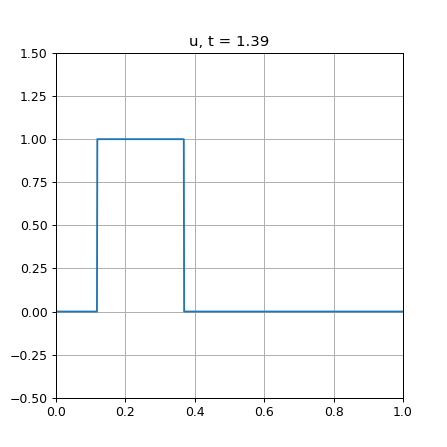

In [4]:
f_fn = lambda x: np.piecewise(x, [x > 0.5, (x <= 0.5) & (x >= 0.25), x < 0.25],
							 [0, 1, 0])
u_fn = lambda x, t: f_fn(x-t - np.floor(x-t))

domain = [0, 1]
T_max = 2.0

x0 = np.linspace(*domain, 1000)
t0 = np.linspace(0, T_max, 100)

from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
line, = ax.plot([], [], lw = 1.5)
ax.set_xlim(domain)
ax.set_ylim([-0.5, 1.5])
ax.grid()

xt0 = [tensor_grid([x0, ti]) for ti in t0]
u0 = [u_fn(xt0_[:, 0:1], xt0_[:, 1:2]) for xt0_ in xt0]

def animate(i):
	line.set_data(x0, u0[i])
	ax.set_title("u, t = {:.2f}".format(t0[i]))
	return line,

anim = animation.FuncAnimation(fig, animate, frames = len(t0), interval = 20, blit = True)
plt.show()

In [5]:
@jax.jit
def mse(pred, true):
	return jnp.mean(jnp.square(pred - true))

@jax.jit
def l2_regularization(params, lambda_0):
	res = 0
	for p in params:
		res += jnp.sum(jnp.square(p[0]))
	return res*lambda_0

@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet, periodic_bc = batch["collocation"], batch["dirichlet"], batch["periodic_bc"]
	direct_params = params
	
	du_dxt = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
	du_dx_c, du_dt_c = du_dxt[:, 0, 0:1], du_dxt[:, 0, 1:2]

	u_d = direct_model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
	bc_left = direct_model(direct_params, jnp.hstack([periodic_bc.left, periodic_bc.t]))
	bc_right = direct_model(direct_params, jnp.hstack([periodic_bc.right, periodic_bc.t]))
	
	loss_c = mse(du_dx_c, -du_dt_c)
	loss_d = mse(u_d, dirichlet.u)
	loss_b = mse(bc_left, bc_right)
	return loss_c, loss_d, loss_b

@jax.jit
def loss_fn(params, batch):
	loss_c, loss_d, loss_b = loss_fn_(params, batch)
	return batch["weights"]["c"]*loss_c + batch["weights"]["d"]*loss_d + batch["weights"]["b"]*loss_b + l2_regularization(params[0], lambda_0)

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	loss_c, loss_d, loss_b = loss_fn_(params, batch)
	return batch["weights"]["c"]*loss_c + batch["weights"]["d"]*loss_d + batch["weights"]["b"]*loss_b, loss_c, loss_d, loss_b

In [6]:
key = random.PRNGKey(1)

# ic
key, subkey = random.split(key, 2)
n_i = 2000
x_i = random.uniform(subkey, (n_i, 1), np.float32, minval = domain[0], maxval = domain[1])
t_i = jnp.zeros_like(x_i)
u_i = u_fn(np.array(x_i), np.array(t_i))

# bc
key, subkey = random.split(key, 2)
n_b = 1000
left = jnp.ones((n_b, 1))*domain[0]
right = jnp.ones((n_b, 1))*domain[1]
t_b = random.uniform(subkey, (n_b, 1), np.float32, minval = 0, maxval = T_max)

# c
n_c = 200
x_c = jnp.linspace(*domain, n_c)
t_c = jnp.linspace(0, T_max, n_c)
tx_c = tensor_grid([t_c, x_c])

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])
dataset_BC = namedtuple("dataset_BC", ["left", "right", "t"])
dirichlet = dataset_Dirichlet(*map(lambda x: jnp.array(x), [x_i, t_i, u_i]))
periodic_bc = dataset_BC(*map(lambda x: jnp.array(x), [left, right, t_b]))
collocation = dataset_Collocation(*map(lambda x: jnp.array(x), [jnp.vstack([tx_c[:, 1:2], dirichlet.x, periodic_bc.left, periodic_bc.right]),
																jnp.vstack([tx_c[:, 0:1], dirichlet.t, periodic_bc.t, periodic_bc.t])]))

class Batch_Generator:
	def __init__(self, key, dataset, batch_size):
		self.key = key
		self.dataset = dataset
		self.batch_size = batch_size
		self.index = jnp.arange(dataset[0].shape[0])
		self.pointer = 0
		self._shuffle()
		
	def _shuffle(self):
		key, subkey = random.split(self.key)
		self.index = random.permutation(subkey, jnp.arange(self.dataset[0].shape[0]))
		self.key = key
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self.pointer >= len(self.index):
			self._shuffle()
			self.pointer = 0
		self.pointer += self.batch_size
		index_ = self.index[self.pointer-self.batch_size:self.pointer]
		return [d[index_, :] for d in self.dataset]

In [7]:
lr = 1e-4
start_iteration = 0
iterations = 100000
print_every = 1000
save_every = 50000
batch_size = {"collocation": 10000, "dirichlet": 1000, "bc": 200}
weights = {"c": 1.0, "d": 10.0, "b": 10.0}

key, *subkeys = random.split(key, 4)

Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
BC = Batch_Generator(subkeys[2], periodic_bc, batch_size["bc"])
params = direct_params

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

for iteration in range(start_iteration+1, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"periodic_bc": dataset_BC(*next(BC)),
		"weights": weights
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "b"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses[0])
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/02, 22:16:01, Iteration: 1000, Train Loss: 8.7318e-01, c: 1.2168e-01, d: 7.4715e-02, b: 4.3510e-04
2020/08/02, 22:16:14, Iteration: 2000, Train Loss: 3.5470e-01, c: 1.2991e-01, d: 2.1452e-02, b: 1.0267e-03
2020/08/02, 22:16:28, Iteration: 3000, Train Loss: 3.1947e-01, c: 1.1544e-01, d: 1.9097e-02, b: 1.3055e-03
2020/08/02, 22:16:41, Iteration: 4000, Train Loss: 3.1826e-01, c: 1.0282e-01, d: 1.9787e-02, b: 1.7575e-03
2020/08/02, 22:16:55, Iteration: 5000, Train Loss: 2.9416e-01, c: 9.0572e-02, d: 1.8553e-02, b: 1.8053e-03
2020/08/02, 22:17:08, Iteration: 6000, Train Loss: 3.0742e-01, c: 9.2803e-02, d: 1.9622e-02, b: 1.8388e-03
2020/08/02, 22:17:22, Iteration: 7000, Train Loss: 2.5516e-01, c: 8.4100e-02, d: 1.5812e-02, b: 1.2946e-03
2020/08/02, 22:17:35, Iteration: 8000, Train Loss: 2.0412e-01, c: 9.1055e-02, d: 1.0480e-02, b: 8.2736e-04
2020/08/02, 22:17:48, Iteration: 9000, Train Loss: 1.8577e-01, c: 7.9744e-02, d: 9.7220e-03, b: 8.8046e-04
2020/08/02, 22:18:02, Iteration: 1000

2020/08/02, 22:32:54, Iteration: 77000, Train Loss: 2.0503e-02, c: 3.7543e-03, d: 1.4934e-03, b: 1.8151e-04
2020/08/02, 22:33:08, Iteration: 78000, Train Loss: 1.0389e-02, c: 3.1888e-03, d: 6.7887e-04, b: 4.1118e-05
2020/08/02, 22:33:21, Iteration: 79000, Train Loss: 1.6530e-02, c: 3.4820e-03, d: 1.1154e-03, b: 1.8934e-04
2020/08/02, 22:33:35, Iteration: 80000, Train Loss: 1.3692e-02, c: 4.3129e-03, d: 8.9356e-04, b: 4.4368e-05
2020/08/02, 22:33:48, Iteration: 81000, Train Loss: 1.2333e-02, c: 4.5726e-03, d: 5.6726e-04, b: 2.0873e-04
2020/08/02, 22:34:01, Iteration: 82000, Train Loss: 1.5187e-02, c: 3.9881e-03, d: 8.6000e-04, b: 2.5993e-04
2020/08/02, 22:34:15, Iteration: 83000, Train Loss: 1.1435e-02, c: 3.2821e-03, d: 7.6414e-04, b: 5.1109e-05
2020/08/02, 22:34:28, Iteration: 84000, Train Loss: 1.3896e-02, c: 3.6469e-03, d: 9.0578e-04, b: 1.1916e-04
2020/08/02, 22:34:41, Iteration: 85000, Train Loss: 1.6943e-02, c: 3.1533e-03, d: 1.1636e-03, b: 2.1537e-04
2020/08/02, 22:34:55, Iterat

<IPython.core.display.Javascript object>


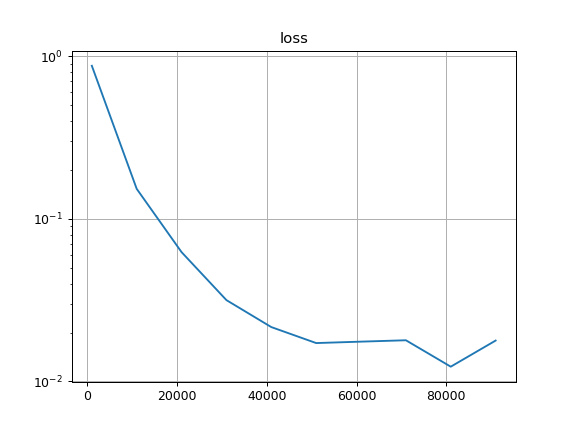

In [8]:
from matplotlib import pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

plt.figure()
plt.semilogy(hist["iter"][::10], hist["loss"][::10])
plt.title("loss")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


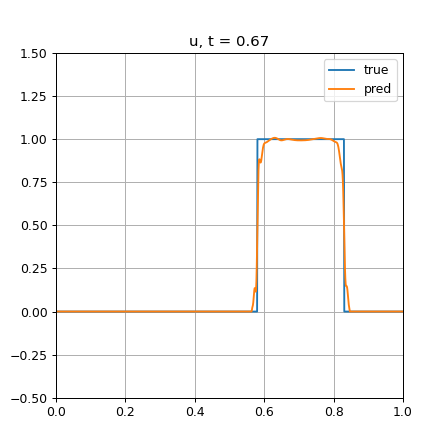

In [13]:
x_test = np.linspace(*domain, 1000)
t_test = np.linspace(0, T_max, 201)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from matplotlib import animation
%matplotlib notebook


params_ = get_params(opt_state)
xt_test = [tensor_grid([x_test, ti]) for ti in t_test]
u_true = [u_fn(xt_test_[:, 0:1], xt_test_[:, 1:2]) for xt_test_ in xt_test]
u_pred = [direct_model(params_, xt_test_) for xt_test_ in xt_test]

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
line1, = ax.plot([], [], lw = 1.5, label = "true")
line2, = ax.plot([], [], lw = 1.5, label = "pred")
ax.set_xlim(domain)
ax.set_ylim([-0.5, 1.5])
ax.grid()
ax.legend()

def animate(i):
	line1.set_data(x_test, u_true[i])
	line2.set_data(x_test, u_pred[i])
	ax.set_title("u, t = {:.2f}".format(t0[i]))
	return [line1, line2]

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 25, blit = True)
plt.show()